In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

### Pull in Data

In [326]:
tech_support = pd.read_csv('../data/1646356302_TalesFromTechSupport.csv')
retail = pd.read_csv('../data/1646356303_TalesFromRetail.csv')
tech_support.shape, retail.shape

((1066, 6), (1080, 6))

### Check Data

In [327]:
tech_support.head()

,author,title,selftext,subreddit,score,created_utc
0,SonDontPlay,"""Where is the router?""",A General Officer calls in for urgent tech sup...,talesfromtechsupport,1183,1638946522
1,talbourne,With users like this...,I'll be staying at this company for a long tim...,talesfromtechsupport,1634,1638904166
2,edhands,Math...what a concept,"Back in 2009, our company purchased a horribly...",talesfromtechsupport,870,1629488107
3,12altoids34,I'll have you know I've been working on comput...,Thats how the call started. \n\nThen she went ...,talesfromtechsupport,935,1623803260
4,Gingrpenguin,We need you to tell us our current password. N...,For backstory i worked for a small tech compan...,talesfromtechsupport,682,1623769022


In [328]:
tech_support.isnull().sum()

author         0
title          0
selftext       0
subreddit      0
score          0
created_utc    0
dtype: int64

In [329]:
tech_support.dtypes

author         object
title          object
selftext       object
subreddit      object
score           int64
created_utc     int64
dtype: object

In [330]:
retail.head()

,author,title,selftext,subreddit,score,created_utc
0,MattyDGames,Your know card doesn’t work? Let’s grab all th...,"Ok ok, today I had a customer come in with a c...",TalesFromRetail,854,1638923563
1,MissMissieFatCat,Woman proves herself wrong and storms out of s...,I work in a family owned pet food/supply store...,TalesFromRetail,756,1623770945
2,Knever,Coworkers try to steal $200 worth of groceries...,"I worked at a grocery store with a guy who, on...",TalesFromRetail,848,1623707257
3,Mr_jon3s,Moves parking cone gets mad that I yelled at h...,Having some work done on the parking lot so we...,TalesFromRetail,602,1623594705
4,pessimist_kitty,Getting real tired of people thinking we're ma...,This just happened this morning and I had to s...,TalesFromRetail,1227,1614891256


In [331]:
retail.isnull().sum()

author         0
title          0
selftext       0
subreddit      0
score          0
created_utc    0
dtype: int64

In [332]:
retail.dtypes

author         object
title          object
selftext       object
subreddit      object
score           int64
created_utc     int64
dtype: object

In [333]:
df = tech_support.append(retail, ignore_index=True)
df.shape

(2146, 6)

### Select Positive Class

TalesFromTechSupport will be my positive class for these models

In [334]:
df['subreddit'] = df['subreddit'].replace({'TalesFromRetail': 0, 'talesfromtechsupport': 1})
df.head()

,author,title,selftext,subreddit,score,created_utc
0,SonDontPlay,"""Where is the router?""",A General Officer calls in for urgent tech sup...,1,1183,1638946522
1,talbourne,With users like this...,I'll be staying at this company for a long tim...,1,1634,1638904166
2,edhands,Math...what a concept,"Back in 2009, our company purchased a horribly...",1,870,1629488107
3,12altoids34,I'll have you know I've been working on comput...,Thats how the call started. \n\nThen she went ...,1,935,1623803260
4,Gingrpenguin,We need you to tell us our current password. N...,For backstory i worked for a small tech compan...,1,682,1623769022


In [335]:
df['subreddit'].value_counts(normalize=True)

0    0.503262
1    0.496738
Name: subreddit, dtype: float64

Nice even split of data, providing good grounds for evaluation of the models.

### Clean Text Data

In [336]:
# From Breakfast Hour lecture https://git.generalassemb.ly/DSIR-0124/Breakfast-Hour/blob/master/06-week/MON%20-%20S%20-%20NLP%20Practice.ipynb

def remove_html(content):
    '''function to remove html and lowercase all text'''
    
    no_html = BeautifulSoup(content).text
    # removes html
    
    lower_case = no_html.lower()
    # lowercase all text
    
    return lower_case

In [337]:
df['clean_title'] = df['title'].apply(remove_html)
df['clean_selftext'] = df['selftext'].apply(remove_html)
df.head()

,author,title,selftext,subreddit,score,created_utc,clean_title,clean_selftext
0,SonDontPlay,"""Where is the router?""",A General Officer calls in for urgent tech sup...,1,1183,1638946522,"""where is the router?""",a general officer calls in for urgent tech sup...
1,talbourne,With users like this...,I'll be staying at this company for a long tim...,1,1634,1638904166,with users like this...,i'll be staying at this company for a long tim...
2,edhands,Math...what a concept,"Back in 2009, our company purchased a horribly...",1,870,1629488107,math...what a concept,"back in 2009, our company purchased a horribly..."
3,12altoids34,I'll have you know I've been working on comput...,Thats how the call started. \n\nThen she went ...,1,935,1623803260,i'll have you know i've been working on comput...,thats how the call started. \n\nthen she went ...
4,Gingrpenguin,We need you to tell us our current password. N...,For backstory i worked for a small tech compan...,1,682,1623769022,we need you to tell us our current password. n...,for backstory i worked for a small tech compan...


### Separate Train and Test Data

In [338]:
X_t = df['clean_title']
X_st = df['clean_selftext']
y = df['subreddit']

In [339]:
X_train_t, X_test_t, y_train, y_test = train_test_split(X_t, y, random_state=42, stratify=y)
# match up 
X_train_st = X_st[X_train_t.index]
X_test_st = X_st[X_test_t.index]

In [340]:
X_train_st.index == X_train_t.index

array([ True,  True,  True, ...,  True,  True,  True])

### Preliminary Model

In [341]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [342]:
# start with a model using the title and default parameters

pipe.fit(X_train_t, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [343]:
print('Train Score:', pipe.score(X_train_t, y_train))
print('Test Score:', pipe.score(X_test_t, y_test))
print('Cross-Val Score:', cross_val_score(pipe, X_train_t, y_train).mean())

Train Score: 0.9627097576134245
Test Score: 0.7001862197392924
Cross-Val Score: 0.7377063137323194


In [344]:
cross_val = cross_val_score(pipe, X_train_t, y_train)

In [345]:
cross_val.std()*3

0.061078663631193034

Very high variance seen in the model, with training data accurately predicting the subreddit 96% of the time with training data, but only 74% of the time with unseen data.

In [346]:
# let's see how selftext does

pipe.fit(X_train_st, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [347]:
print('Train Score:', pipe.score(X_train_st, y_train))
print('Test Score:', pipe.score(X_test_st, y_test))
cross_val = cross_val_score(pipe, X_train_st, y_train)
print('Cross-Val Score:', cross_val.mean())

Train Score: 1.0
Test Score: 0.9553072625698324
Cross-Val Score: 0.9589887966564115


In [348]:
sig_3 = cross_val.std()*3
print('Cross-Val Standard Deviation:', '{:.4f}'.format(cross_val.std()))
print('Accuracy range between:', '{:.2f}'.format(cross_val.mean() - sig_3), 'and', '{:.2f}'.format(cross_val.mean() + sig_3))

Cross-Val Standard Deviation: 0.0136
Accuracy range between: 0.92 and 1.00


Wow, much better. As expected, the volume of the text has a significant affect on performance. Still a bit of variance, but already the model is doing an excellent job predicting unseen data with 96% accuracy. We are overfitting a bit it seems, with 99% accuracy on the training data, so we may be able to squeeze some performance by stripping out some of the features (maybe with LASSO).

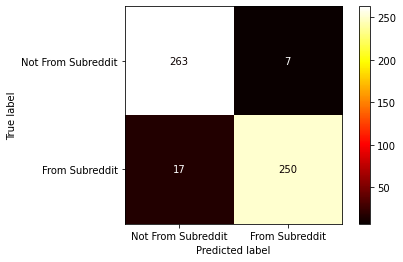

In [349]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(pipe, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'))

In [350]:
pred = pipe.predict(X_test_st)

In [351]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       270
           1       0.97      0.94      0.95       267

    accuracy                           0.96       537
   macro avg       0.96      0.96      0.96       537
weighted avg       0.96      0.96      0.96       537



This basic logistic regression model outperforms the baseline (50% accuracy when guessing all posts are not from the target subreddit) with 96% accuracy, and is relatively balanced in its false positive/false negative rates with 97% specificity and 94% recall rates. We already have a solid model for predicting post origin based on these results. 

### Tune Model

I'm going to start by taking a look at what the model's top features based on coefficient magnitude

In [352]:
# approach found at https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn
vectorizer = pipe.named_steps['cvec']
classifier = pipe.named_steps['logreg']
coefs_st = classifier.coef_[0]
coefs_st

array([-4.56744547e-04, -2.78385233e-02, -1.35721690e-07, ...,
       -4.30916383e-03, -1.52884924e-02, -4.30916383e-03])

In [353]:
coefs_st.shape

(19678,)

In [354]:
features_st = vectorizer.get_feature_names_out()
features_st

array(['00', '000', '0000', ..., 'ɽʉ', 'ಠ_ಠ', 'ⱨɏ'], dtype=object)

In [355]:
features_st.shape

(19678,)

In [356]:
feature_coefs = pd.Series(index=features_st, data=coefs_st)
sorted_features = feature_coefs.sort_values(ascending=False)

In [357]:
sorted_features.head(20)

support      0.875610
tech         0.786294
user         0.562323
computer     0.548120
email        0.464021
problem      0.452407
call         0.439518
office       0.433339
desk         0.428817
new          0.413714
data         0.388069
calls        0.379711
ticket       0.370938
monitor      0.367675
power        0.361246
network      0.352143
computers    0.350543
work         0.345155
button       0.338920
client       0.332842
dtype: float64

Notably, "computer" and "computers" both make it onto the list (which makes sense as a dead giveaway...) as separate items; I'd be interested in seeing how a stemmer impacts performance. And then the words "tech" and "support" being the top words is certainly no surprise. I hadn't originally considered that "office" would be strongly tied to tech support, but obviously retail business is not typically conducted in an office, so I feel a little silly for not having identified that for myself beforehand. 

In [358]:
sorted_features.tail(20)

customers   -0.266079
item        -0.268296
price       -0.273337
sir         -0.277150
came        -0.280348
want        -0.281857
gift        -0.293282
items       -0.305090
return      -0.306008
cashier     -0.336479
have        -0.340081
sale        -0.341846
shop        -0.350077
sorry       -0.359522
register    -0.385279
counter     -0.408464
woman       -0.449794
man         -0.453571
retail      -0.495509
store       -1.167985
dtype: float64

The words shown here point away from the target subreddit, and towards our opposing subreddit, "TalesFromRetail". It appears here as well that applying a stemmer could be useful, but otherwise most of the words seem to make sense. Some interesting standouts in "have" and "want" being in this list; curious to me that those would be used more frequently in retail relative to tech support.

In [359]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('logreg', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'logreg': LogisticRegression(max_iter=1000),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 1000,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solv

Okay, let's see how cutting down the number of words using a stemmer and dropping stop words in the vectorizer, and using LASSO with the logistic regression, affects things. 

In [360]:
# approach from https://git.generalassemb.ly/DSIR-0124/Breakfast-Hour/blob/master/06-week/MON%20-%20S%20-%20NLP%20Practice.ipynb

def stem_content(content):
    p_stemmer = PorterStemmer()
    split_content = content.split(' ')
    return [p_stemmer.stem(word) for word in split_content]

In [361]:
t_start = int(time.time())

np.random.seed(42)
params1 = {
    'cvec__tokenizer': [None, stem_content],
    'cvec__stop_words': [None, 'english'],
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [1.0, .7, .4]
}

gs1 = GridSearchCV(pipe, params1)
gs1.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs1.best_score_)
print(gs1.best_params_)

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sor

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sor

Time to complete: 9 min, 35 seconds
0.963336622743368
{'cvec__stop_words': 'english', 'cvec__tokenizer': None, 'logreg__C': 0.4, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [362]:
print('Train Score:', gs1.score(X_train_st, y_train))
print('Test Score:', gs1.score(X_test_st, y_test))
print('Cross-Val Score:', gs1.best_score_)

Train Score: 0.9968924798011187
Test Score: 0.9590316573556797
Cross-Val Score: 0.963336622743368


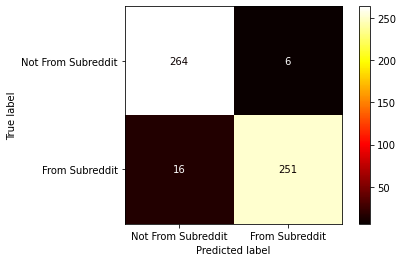

In [363]:
ConfusionMatrixDisplay.from_estimator(gs1, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'))

In [364]:
# approach from https://git.generalassemb.ly/DSIR-0124/lesson-hyperparameters-gridsearch-and-pipelines/blob/master/starter-code.ipynb

pd.DataFrame(gs1.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__stop_words,param_cvec__tokenizer,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.607380,0.010171,0.132036,0.004324,english,None,0.4,l1,liblinear,"{'cvec__stop_words': 'english', 'cvec__tokeniz...",0.968944,0.944099,0.972050,0.959627,0.971963,0.963337,0.010636,1
6,0.608593,0.008035,0.131241,0.007494,english,None,1.0,l1,liblinear,"{'cvec__stop_words': 'english', 'cvec__tokeniz...",0.968944,0.956522,0.962733,0.959627,0.968847,0.963335,0.004947,2
7,0.608784,0.010775,0.132048,0.005630,english,None,0.7,l1,liblinear,"{'cvec__stop_words': 'english', 'cvec__tokeniz...",0.965839,0.950311,0.965839,0.953416,0.968847,0.960850,0.007484,3
0,0.727850,0.017151,0.144826,0.006164,None,None,1.0,l1,liblinear,"{'cvec__stop_words': None, 'cvec__tokenizer': ...",0.962733,0.944099,0.962733,0.962733,0.950156,0.956491,0.007881,4
1,0.714493,0.011954,0.145418,0.004151,None,None,0.7,l1,liblinear,"{'cvec__stop_words': None, 'cvec__tokenizer': ...",0.962733,0.944099,0.959627,0.962733,0.947040,0.955247,0.008036,5


Not much difference there, with the particular exception that english stop words significantly reduced the cross_val standard deviation in the number 2 spot. On our original model, we were seeing a standard deviation of around .014, and that particular version of the model more than halves that down to .005. This is great; the overall variance of our model is diminishing, even though we aren't yet seeing much affect on our train and test scores.

Also of note, the Train score remains very close to perfect; I want to try and push that down away from overfitting and try to give some room to swap bias for variance (thinking that will bring the cross-val and test scores up along the way)

In [365]:
gs1.best_estimator_[0]

CountVectorizer(stop_words='english')

In [366]:
gs1.best_estimator_[1]

LogisticRegression(C=0.4, max_iter=1000, penalty='l1', solver='liblinear')

For our count vectorizor, stemming didn't appear to help much, but stop words certainly seemed to help in some cases with variance. Next, I'd like to get a little better resolution on regularization strength values, and try to cut down features a bit more.

In [367]:
t_start = int(time.time())

np.random.seed(42)
params2 = {
#     'cvec__tokenizer': [None, stem_content], # tokenizer didn't seem to help
    'cvec__stop_words': ['english'], # english stop words bought down our standard deviation considerably
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [.8, .7, .6, .5, .4, .3, .2, .1]
}

gs2 = GridSearchCV(pipe, params2)
gs2.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs2.best_score_)
print(gs2.best_params_)

Time to complete: 0 min, 31 seconds
0.9652019117277142
{'cvec__stop_words': 'english', 'logreg__C': 0.3, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [368]:
print('Train Score:', gs2.score(X_train_st, y_train))
print('Test Score:', gs2.score(X_test_st, y_test))
print('Cross-Val Score:', gs2.best_score_)

Train Score: 0.9931634555624611
Test Score: 0.9553072625698324
Cross-Val Score: 0.9652019117277142


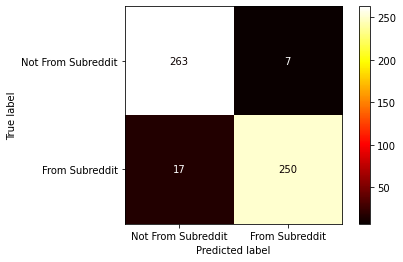

In [369]:
ConfusionMatrixDisplay.from_estimator(gs2, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'))

In [419]:
pd.DataFrame(gs2.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__stop_words,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.614942,0.008035,0.133058,0.006796,english,0.3,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.965839,0.947205,0.975155,0.962733,0.975078,0.965202,0.010266,1
4,0.605374,0.010572,0.132453,0.006359,english,0.4,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.968944,0.944099,0.972050,0.959627,0.968847,0.962714,0.010194,2
3,0.622922,0.009648,0.132848,0.004937,english,0.5,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.968944,0.947205,0.972050,0.953416,0.968847,0.962092,0.009886,3
6,0.619725,0.008653,0.130865,0.003413,english,0.2,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.968944,0.950311,0.965839,0.956522,0.968847,0.962092,0.007436,3
0,0.618957,0.005091,0.135837,0.003943,english,0.8,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.965839,0.953416,0.962733,0.956522,0.968847,0.961471,0.005735,5
1,0.621923,0.019045,0.137246,0.004501,english,0.7,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.965839,0.950311,0.965839,0.956522,0.968847,0.961471,0.006951,5
2,0.650061,0.013261,0.139433,0.010134,english,0.6,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.968944,0.947205,0.968944,0.953416,0.968847,0.961471,0.009322,5
7,0.598990,0.009396,0.132253,0.003452,english,0.1,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.965839,0.947205,0.947205,0.962733,0.959502,0.956497,0.007847,8


Okay, looks like we're starting to split hairs with the regularization strengths. Seeing solid performance with practically all of the models producing greater than 96% accuracy, but index 0 catches my attention with a standard deviation around .6%.  

One last thing I'd like to try with this logistic regression model is to incorporate n-grams; I suspect that there are a number of word combinations that would be strong indicators for our subreddits. 

In [371]:
t_start = int(time.time())

np.random.seed(42)
params3 = {
    'cvec__stop_words': ['english'], # english stop words bought down our standard deviation considerably
    'cvec__ngram_range': [(2,2), (1,2)], # explore two-word space
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [.6, .55, .5] # exploring the space between the two previous best regularization strengths (assuming indepence from other params)
}

gs3 = GridSearchCV(pipe, params3)
gs3.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs3.best_score_)
print(gs3.best_params_)

Time to complete: 0 min, 59 seconds
0.9627135697838665
{'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'logreg__C': 0.55, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [372]:
print('Train Score:', gs3.score(X_train_st, y_train))
print('Test Score:', gs3.score(X_test_st, y_test))
print('Cross-Val Score:', gs3.best_score_)

Train Score: 0.9981354878806712
Test Score: 0.9590316573556797
Cross-Val Score: 0.9627135697838665


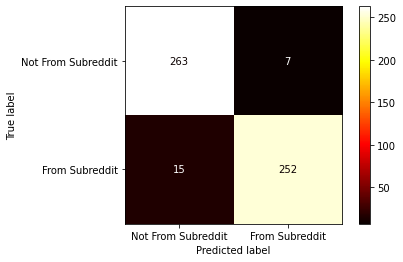

In [373]:
ConfusionMatrixDisplay.from_estimator(gs3, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'));

In [374]:
pd.DataFrame(gs3.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__ngram_range,param_cvec__stop_words,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.867404,0.031322,0.212244,0.006065,"(1, 2)",english,0.55,l1,liblinear,"{'cvec__ngram_range': (1, 2), 'cvec__stop_word...",0.968944,0.947205,0.972050,0.956522,0.968847,0.962714,0.009407,1
3,1.842272,0.048860,0.213003,0.002731,"(1, 2)",english,0.6,l1,liblinear,"{'cvec__ngram_range': (1, 2), 'cvec__stop_word...",0.968944,0.947205,0.968944,0.953416,0.968847,0.961471,0.009322,2
5,1.851242,0.031277,0.208042,0.006562,"(1, 2)",english,0.5,l1,liblinear,"{'cvec__ngram_range': (1, 2), 'cvec__stop_word...",0.968944,0.944099,0.972050,0.953416,0.968847,0.961471,0.010852,2
0,1.514356,0.030692,0.167152,0.004261,"(2, 2)",english,0.6,l1,liblinear,"{'cvec__ngram_range': (2, 2), 'cvec__stop_word...",0.835404,0.838509,0.832298,0.832298,0.778816,0.823465,0.022443,4
2,1.518130,0.016660,0.169561,0.007734,"(2, 2)",english,0.5,l1,liblinear,"{'cvec__ngram_range': (2, 2), 'cvec__stop_word...",0.844720,0.835404,0.832298,0.835404,0.769470,0.823459,0.027314,5


Okay, looks like my hypothesis proved to be false! There was no real difference with 2 word combinations. I am curious if there were any 2-grams that made the top twenty...

In [375]:
# approach from https://stackoverflow.com/questions/24375911/how-to-print-estimated-coefficients-after-a-gridsearchcv-fit-a-model-sgdregr

vectorizer_gs3 = gs3.best_estimator_.named_steps['cvec']
classifier_gs3 = gs3.best_estimator_.named_steps['logreg']

In [376]:
coefs_gs3_st = classifier_gs3.coef_[0]
features_gs3_st = vectorizer_gs3.get_feature_names_out()
feature_gs3_coefs = pd.Series(index=features_gs3_st, data=coefs_gs3_st)
sorted_features_gs3 = feature_gs3_coefs.sort_values(ascending=False)

In [377]:
sorted_features_gs3.head(20)

computers      1.824913
support        1.719936
network        1.115989
data           1.026781
fix            0.975395
tech           0.854424
problem        0.841902
user           0.834281
details        0.758208
ticket         0.730991
computer       0.705670
information    0.700590
monitor        0.683161
sent           0.620347
desk           0.599361
office         0.590949
client         0.579275
server         0.553508
new            0.534602
log            0.525570
dtype: float64

In [378]:
sorted_features_gs3.tail(20)

busy        -0.278969
hands       -0.302457
said        -0.311641
customers   -0.359170
employee    -0.380831
gas         -0.381271
shop        -0.426240
man         -0.433944
want        -0.443806
okay        -0.468196
parking     -0.486602
sell        -0.535951
sorry       -0.564872
return      -0.575009
items       -0.600794
sale        -0.614370
woman       -0.680206
retail      -1.153958
counter     -1.174769
store       -1.238937
dtype: float64

Wow, not a single one! Just out of curiosity I want to see the 3-gram space.

In [379]:
t_start = int(time.time())

np.random.seed(42)
params4 = {
    'cvec__stop_words': ['english'], # english stop words bought down our standard deviation considerably
    'cvec__ngram_range': [(1,2), (1,3)], # explore two-word and three-word space
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [.65, .6, .55] # exploring the space between the two previous best regularization strengths (assuming indepence from other params)
}

gs4 = GridSearchCV(pipe, params4)
gs4.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs4.best_score_)
print(gs4.best_params_)

Time to complete: 1 min, 31 seconds
0.9627135697838665
{'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'logreg__C': 0.55, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [380]:
print('Train Score:', gs4.score(X_train_st, y_train))
print('Test Score:', gs4.score(X_test_st, y_test))
print('Cross-Val Score:', gs4.best_score_)

Train Score: 0.9981354878806712
Test Score: 0.9590316573556797
Cross-Val Score: 0.9627135697838665


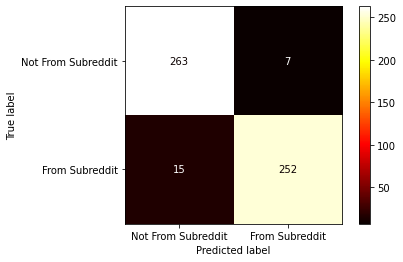

In [381]:
ConfusionMatrixDisplay.from_estimator(gs4, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'));

In [382]:
pd.DataFrame(gs4.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__ngram_range,param_cvec__stop_words,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,1.835489,0.035910,0.211029,0.013660,"(1, 2)",english,0.55,l1,liblinear,"{'cvec__ngram_range': (1, 2), 'cvec__stop_word...",0.968944,0.947205,0.968944,0.959627,0.968847,0.962714,0.008548,1
4,3.536152,0.086540,0.280855,0.010338,"(1, 3)",english,0.6,l1,liblinear,"{'cvec__ngram_range': (1, 3), 'cvec__stop_word...",0.968944,0.950311,0.968944,0.956522,0.968847,0.962714,0.007841,1
5,3.498875,0.039769,0.279659,0.010111,"(1, 3)",english,0.55,l1,liblinear,"{'cvec__ngram_range': (1, 3), 'cvec__stop_word...",0.968944,0.947205,0.968944,0.959627,0.968847,0.962714,0.008548,1
1,1.868006,0.010980,0.216416,0.014306,"(1, 2)",english,0.6,l1,liblinear,"{'cvec__ngram_range': (1, 2), 'cvec__stop_word...",0.968944,0.947205,0.968944,0.956522,0.968847,0.962092,0.008857,4
3,3.488673,0.053516,0.280044,0.015865,"(1, 3)",english,0.65,l1,liblinear,"{'cvec__ngram_range': (1, 3), 'cvec__stop_word...",0.968944,0.950311,0.965839,0.953416,0.968847,0.961471,0.007985,5


And with three, we get more of the same kinds of results. Looks like we're best off with just the individual words.

Alright, last bit to explore is max and min counts for the vectorizer. I'm running out of ideas to drive down the overfitting and buy back some variance...

In [383]:
t_start = int(time.time())

np.random.seed(42)
params5 = {
    'cvec__stop_words': ['english'],
    'cvec__max_df': [1.0, .8, .6, .4], # explore limiting words that show up throughout the corpus
    'cvec__min_df': [.00, .05, .10, .20], # # explore limiting words that don't show up throughout the corpus
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [.6]
}

gs5 = GridSearchCV(pipe, params5)
gs5.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs5.best_score_)
print(gs5.best_params_)

Time to complete: 0 min, 58 seconds
0.9633327528492096
{'cvec__max_df': 0.8, 'cvec__min_df': 0.05, 'cvec__stop_words': 'english', 'logreg__C': 0.6, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [384]:
print('Train Score:', gs5.score(X_train_st, y_train))
print('Test Score:', gs5.score(X_test_st, y_test))
print('Cross-Val Score:', gs5.best_score_)

Train Score: 0.9987569919204475
Test Score: 0.9534450651769087
Cross-Val Score: 0.9633327528492096


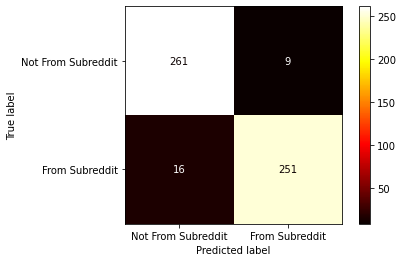

In [385]:
ConfusionMatrixDisplay.from_estimator(gs5, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'));

In [386]:
pd.DataFrame(gs5.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__min_df,param_cvec__stop_words,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.565699,0.011755,0.128044,0.005802,0.8,0.05,english,0.6,l1,liblinear,"{'cvec__max_df': 0.8, 'cvec__min_df': 0.05, 'c...",0.956522,0.962733,0.965839,0.965839,0.965732,0.963333,0.003607,1
9,0.575268,0.009420,0.130244,0.003858,0.6,0.05,english,0.6,l1,liblinear,"{'cvec__max_df': 0.6, 'cvec__min_df': 0.05, 'c...",0.956522,0.959627,0.968944,0.965839,0.965732,0.963333,0.004553,1
1,0.569275,0.010218,0.132846,0.004522,1.0,0.05,english,0.6,l1,liblinear,"{'cvec__max_df': 1.0, 'cvec__min_df': 0.05, 'c...",0.953416,0.962733,0.965839,0.965839,0.965732,0.962712,0.004798,3
4,0.620139,0.025414,0.133445,0.006031,0.8,0.0,english,0.6,l1,liblinear,"{'cvec__max_df': 0.8, 'cvec__min_df': 0.0, 'cv...",0.968944,0.950311,0.968944,0.953416,0.968847,0.962092,0.008410,4
0,0.620539,0.010495,0.139023,0.006553,1.0,0.0,english,0.6,l1,liblinear,"{'cvec__max_df': 1.0, 'cvec__min_df': 0.0, 'cv...",0.968944,0.947205,0.968944,0.953416,0.968847,0.961471,0.009322,5


In [387]:
gs5_res = pd.DataFrame(gs5.cv_results_)

In [388]:
gs5_res[gs5_res['param_cvec__max_df'] == .4]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__min_df,param_cvec__stop_words,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.629316,0.005170,0.135435,0.002468,0.4,0.0,english,0.6,l1,liblinear,"{'cvec__max_df': 0.4, 'cvec__min_df': 0.0, 'cv...",0.962733,0.953416,0.962733,0.953416,0.968847,0.960229,0.005994,6
13,0.579043,0.021858,0.133445,0.006774,0.4,0.05,english,0.6,l1,liblinear,"{'cvec__max_df': 0.4, 'cvec__min_df': 0.05, 'c...",0.953416,0.947205,0.968944,0.944099,0.956386,0.954010,0.008644,8
14,0.575048,0.009363,0.127936,0.004041,0.4,0.1,english,0.6,l1,liblinear,"{'cvec__max_df': 0.4, 'cvec__min_df': 0.1, 'cv...",0.925466,0.922360,0.950311,0.925466,0.931464,0.931013,0.010090,12
15,0.571469,0.005104,0.127661,0.006509,0.4,0.2,english,0.6,l1,liblinear,"{'cvec__max_df': 0.4, 'cvec__min_df': 0.2, 'cv...",0.813665,0.881988,0.919255,0.854037,0.931464,0.880082,0.043053,16


Interesting! This appears to be our best performing model! Not only does the top model of gs5 have 96.3% accuracy, but it also has the lowest standard deviation yet at .36%

### How does our model do with a related subreddit?

In [389]:
questions = pd.read_csv('../data/1646356406_ITCareerQuestions.csv')

In [390]:
questions.head()

,author,title,selftext,subreddit,score,created_utc
0,CrustyNippleFlakes,Do you guys ever feel guilty for your salary c...,I'm getting paid 60k a year right now as a sin...,ITCareerQuestions,1,1646353382
1,MisterPuffyNipples,"What's your ""I give up"" story when working at ...",I'm not quitting. I'm just gonna go in and hal...,ITCareerQuestions,1,1646352687
2,BonesBroberg,"Network Administrator Degree, what the classes...",Who has a major in network administration and ...,ITCareerQuestions,1,1646352374
3,Michaelscott304,Help deciding between 2 offers …I’m stressing ...,I’m really undecided on what to do. My goal is...,ITCareerQuestions,1,1646351286
4,Smug-Vulture,Recent Cloud/DevOps Engineering Job Hunting Ex...,Throwaway because some people at my current jo...,ITCareerQuestions,1,1646350298


In [391]:
questions.isnull().sum()

author         0
title          0
selftext       0
subreddit      0
score          0
created_utc    0
dtype: int64

In [392]:
df2 = tech_support.append(questions, ignore_index=True)
df2.shape

(2092, 6)

In [393]:
df2.tail()

,author,title,selftext,subreddit,score,created_utc
2087,pvtdixynormus,Almost done with associates and not sure the b...,I’m almost done with my associates for CS and ...,ITCareerQuestions,1,1644763296
2088,shamrok27,Getting a security job without an IT degree or...,Hey folks! I was hoping someone could either g...,ITCareerQuestions,1,1644761778
2089,Cephalon_Zeash,Sysadmin VS Devops for a highschooler looking ...,As a highschooler looking into various technol...,ITCareerQuestions,1,1644757832
2090,Opambour-ade3d3hene,I need help with IT Support Coordinator Interv...,I applied for a System Administrator position ...,ITCareerQuestions,1,1644756801
2091,Obvious-Scallion6963,Where can I find jobs that will teach me SQL? ...,I am entering my senior year in ISM with a his...,ITCareerQuestions,1,1644742802


In [394]:
df2['subreddit'] = df2['subreddit'].replace({'ITCareerQuestions': 0, 'talesfromtechsupport': 1})
df2.head()

,author,title,selftext,subreddit,score,created_utc
0,SonDontPlay,"""Where is the router?""",A General Officer calls in for urgent tech sup...,1,1183,1638946522
1,talbourne,With users like this...,I'll be staying at this company for a long tim...,1,1634,1638904166
2,edhands,Math...what a concept,"Back in 2009, our company purchased a horribly...",1,870,1629488107
3,12altoids34,I'll have you know I've been working on comput...,Thats how the call started. \n\nThen she went ...,1,935,1623803260
4,Gingrpenguin,We need you to tell us our current password. N...,For backstory i worked for a small tech compan...,1,682,1623769022


In [395]:
df2['subreddit'].value_counts(normalize=True)

1    0.50956
0    0.49044
Name: subreddit, dtype: float64

In [396]:
df2['clean_selftext'] = df2['selftext'].apply(remove_html)

In [397]:
df2.shape

(2092, 7)

In [398]:
X2 = df2['clean_selftext']
y2 = df2['subreddit']

In [399]:
X2.shape, y2.shape

((2092,), (2092,))

In [400]:
# for some reason this was breaking when using stratify...
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, stratify=y) 

In [401]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42)

In [420]:
# Using top performing parameters from earlier tuned model gs5:({'cvec__max_df': 0.8, 'cvec__min_df': 0.05, 'cvec__stop_words': 'english', 'logreg__C': 0.6, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'})

pipe2 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', max_df=0.8, min_df=0.05)),
    ('logreg', LogisticRegression(max_iter=1000, C=0.6, penalty='l1', solver='liblinear'))
])

In [421]:
pipe2.fit(X_train2, y_train2)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.8, min_df=0.05,
                                 stop_words='english')),
                ('logreg',
                 LogisticRegression(C=0.6, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [422]:
y_train2.value_counts(normalize=True)

1    0.505417
0    0.494583
Name: subreddit, dtype: float64

Let's see how we do...

In [423]:
print('Train Score:', pipe2.score(X_train2, y_train2))
print('Test Score:', pipe2.score(X_test2, y_test2))
cross_val2 = cross_val_score(pipe2, X_train2, y_train2)
print('Cross-Val Score:', cross_val2.mean())

Train Score: 0.9980879541108987
Test Score: 0.9655831739961759
Cross-Val Score: 0.9706741824545695


In [424]:
sig_3_2 = cross_val2.std()*3
print('Cross-Val Standard Deviation:', '{:.4f}'.format(cross_val2.std()))
print('Accuracy range between: ' + str('{:.1f}'.format((cross_val2.mean() - sig_3_2) * 100)) + '% and ' + str('{:.1f}'.format((cross_val2.mean() + sig_3_2) * 100)) + '%')

Cross-Val Standard Deviation: 0.0071
Accuracy range between: 94.9% and 99.2%


Excellent! The performance of the model looks excellent when comparing these two subreddits even though their content subject matter was expected to be more similar and assumed to have common terms! Let's look at the key contributors:

In [425]:
vectorizer2 = pipe2.named_steps['cvec']
classifier2 = pipe2.named_steps['logreg']
coefs2 = classifier2.coef_[0]
coefs2

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.33122336,
        0.        ,  0.        ,  0.        , -0.05099701,  0.67416855,
       -0.59158454,  0.        ,  0.        ,  0.        ,  0.58218039,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.07463834,
        0.        ,  0.48504916,  0.74792403,  0.        ,  0.        ,
        0.        ,  0.47253959,  0.18894929,  0.72882315,  0.        ,
        0.29420674,  0.        ,  0.        , -0.17773411,  0.        ,
       -0.07292389,  0.        ,  0.        ,  0.54754588,  0.2473075 ,
        0.45025701,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.02371699,  0.        ,  0.56980742,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.24420981,
        0.        , -0.13167538, -1.07992655,  0.35119346,  0.  

In [426]:
features2 = vectorizer2.get_feature_names_out()
features2

array(['10', '20', '30', 'able', 'access', 'account', 'actually', 'admin',
       'advice', 'ago', 'answer', 'apparently', 'area', 'ask', 'asked',
       'asking', 'away', 'background', 'bad', 'based', 'basic',
       'basically', 'best', 'better', 'big', 'bit', 'boss', 'box',
       'break', 'building', 'business', 'button', 'cable', 'called',
       'calling', 'calls', 'came', 'care', 'career', 'case', 'certs',
       'change', 'changed', 'check', 'click', 'client', 'clients',
       'close', 'cloud', 'college', 'com', 'come', 'comes', 'coming',
       'companies', 'company', 'completely', 'computer', 'computers',
       'connect', 'contract', 'conversation', 'correct', 'couldn',
       'couple', 'course', 'current', 'currently', 'customer',
       'customers', 'data', 'day', 'days', 'deal', 'decided', 'degree',
       'department', 'desk', 'desktop', 'did', 'didn', 'different',
       'does', 'doesn', 'doing', 'don', 'door', 'dr', 'drive', 'easy',
       'email', 'emails', 'employee

In [427]:
feature_coefs2 = pd.Series(index=features2, data=coefs2)
sorted_features2 = feature_coefs2.sort_values(ascending=False)

In [428]:
sorted_features2.head(20)

room       1.383802
oh         1.184278
went       1.093944
today      1.042996
ok         1.000613
user       0.966102
screen     0.892938
box        0.747924
called     0.728823
guy        0.717111
later      0.713480
yes        0.681731
ago        0.674169
night      0.659192
wants      0.619103
email      0.618299
day        0.602922
wasn       0.598886
sorry      0.597015
morning    0.586857
dtype: float64

In [429]:
sorted_features2.tail(20)

ve           -0.143428
making       -0.147720
career       -0.177734
questions    -0.352209
position     -0.360664
feel         -0.385848
really       -0.421316
field        -0.462516
desktop      -0.471478
offer        -0.586011
answer       -0.591585
jobs         -0.635817
role         -0.638483
interview    -0.786854
job          -0.860729
months       -0.877333
learn        -1.014248
currently    -1.079927
experience   -1.151648
degree       -1.261559
dtype: float64

Well, that explains it! Although it is an IT subreddit, the main focus of the content is on career development, and as such we see terms that really only make sense in that context.

In [430]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs2.predict_proba(X_test_st)[:,1]})

pred_df.head()

,true_values,pred_probs
150,1,8.772184e-01
1345,0,2.007860e-05
1957,0,2.332188e-02
1792,0,2.295138e-02
1707,0,1.201654e-12


C:\Users\musou\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


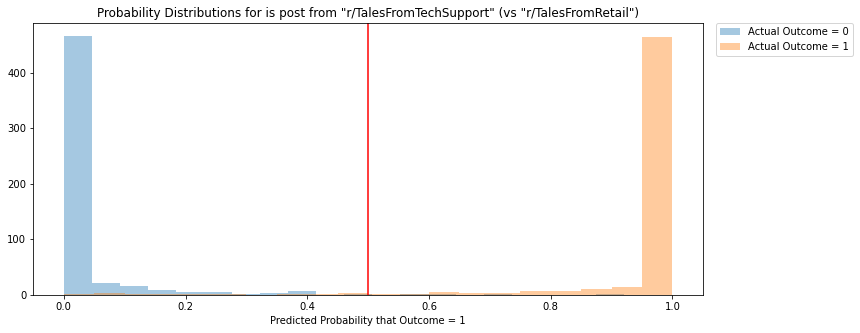

In [431]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(.5, color='r')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title('Probability Distributions for is post from "r/TalesFromTechSupport" (vs "r/TalesFromRetail")')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0);

In [432]:
# approach from https://git.generalassemb.ly/DSIR-0124/lesson-classification-metrics-ii/blob/master/starter-code.ipynb

pred_df2 = pd.DataFrame({'true_values': y_test2,
                        'pred_probs': pipe2.predict_proba(X_test2)[:,1]})

pred_df2.head()

,true_values,pred_probs
1280,0,0.165124
29,1,0.936692
210,1,0.999939
1730,0,0.000019
584,1,0.999220


C:\Users\musou\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


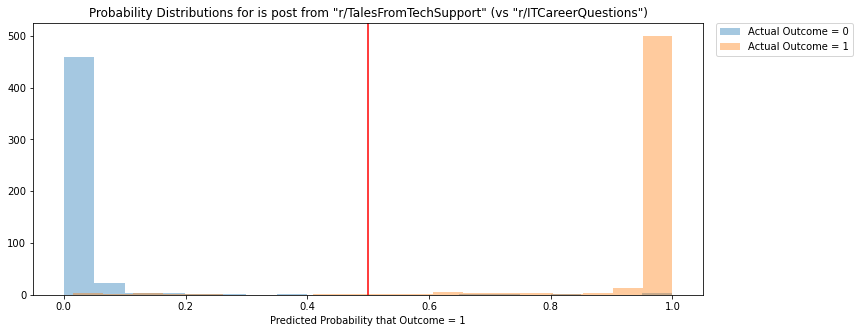

In [433]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df2.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(.5, color='r')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title('Probability Distributions for is post from "r/TalesFromTechSupport" (vs "r/ITCareerQuestions")')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0);

Let's look at where the model got the predictions wrong

In [434]:
false_neg_2 = pred_df2[(pred_df2['true_values'] == 1) & (pred_df2['pred_probs'] < .5)]
false_neg_2

,true_values,pred_probs
829,1,0.210270
605,1,0.477885
409,1,0.143615
788,1,0.254940
184,1,0.153382
808,1,0.128394
599,1,0.039829
256,1,0.015106
757,1,0.029156
907,1,0.083136


In [435]:
false_pos_2 = pred_df2[(pred_df2['true_values'] == 0) & (pred_df2['pred_probs'] > .5)]
false_pos_2

,true_values,pred_probs
1959,0,0.651244
1176,0,0.999929
1988,0,0.829151
2084,0,0.999004
1302,0,0.996717
1900,0,0.744780
1519,0,0.987128


In [436]:
X2[false_neg_2.index]

829    we have a performance benchmarking environment...
605    hey guys, i work for a small msp that supports...
409    good afternoon tfts! got a short and sweet one...
788    i do support for a web application. the app it...
184    in the grim, dark future of the 21st millenniu...
808    i fell into a role assisting our service desk ...
599    my father recently passed away, and he worked ...
256    our company consists of 8 different locations,...
757    quick family tech support with a life lesson.\...
907    this is my first post ever on reddit, so pleas...
331    one of our clients called in complaining that ...
Name: clean_selftext, dtype: object

Lets look at some of the qualities of these posts to see if anything stands out